In [8]:
!pip install keras-tuner -qq


In [11]:
# Importar las librerías necesarias
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.layers import Dense, Dropout

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import keras_tuner as kt

# Cargar el dataset MNIST
(X_train_full, y_train_full), (X_test, y_test) = mnist.load_data()

# Preprocesamiento de los datos
X_train_full = X_train_full.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Dividir el dataset de entrenamiento en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

# Aplanar las imágenes 28x28 en vectores de 784
X_train = X_train.reshape(-1, 28, 28)
X_val = X_val.reshape(-1, 28, 28)
X_test = X_test.reshape(-1, 28, 28)

# Codificar las etiquetas en formato one-hot
y_train = to_categorical(y_train, 10)
y_val = to_categorical(y_val, 10)
y_test = to_categorical(y_test, 10)



# Definir la función de construcción del modelo CNN para la búsqueda de hiperparámetros
def build_model(hp):
    model = Sequential()

    # Primera capa convolucional
    model.add(Conv2D(
        filters=hp.Int('filters_1', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('kernel_size_1', values=[3, 5]),
        activation='relu',
        input_shape=(28, 28, 1)
    ))

    # Capa de MaxPooling para reducir la dimensionalidad
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Segunda capa convolucional
    model.add(Conv2D(
        filters=hp.Int('filters_2', min_value=64, max_value=128, step=32),
        kernel_size=hp.Choice('kernel_size_2', values=[3, 5]),
        activation='relu'
    ))

    # Otra capa de MaxPooling
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Aplanar las capas convolucionales a un vector 1D para conectarlas a capas densas
    model.add(Flatten())

    # Capa densa totalmente conectada
    model.add(Dense(units=hp.Int('units', min_value=128, max_value=512, step=64), activation='relu'))

    # Añadir una capa de Dropout para evitar overfitting
    model.add(Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))

    # Capa de salida con 10 neuronas para las 10 clases de MNIST
    model.add(Dense(10, activation='softmax'))

    # Compilar el modelo
    model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop']),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


In [12]:
# Red Densa
# 28 minutos con una T4 de Google Colab

# CNN
#

# Configurar el tunning de hiperparámetros usando KerasTuner
tuner = kt.RandomSearch(
    build_model,                    # Función para construir el modelo
    objective='val_accuracy',        # Métrica a optimizar
    max_trials=8,                    # Número máximo de configuraciones que probar
    executions_per_trial=2,          # Ejecutar cada configuración 2 veces para más estabilidad
    directory='my_dir',              # Directorio para almacenar los resultados
    project_name='mnist_tuning')     # Nombre del proyecto

# Realizar la búsqueda de hiperparámetros
tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val))




Trial 8 Complete [00h 02m 51s]
val_accuracy: 0.9909583330154419

Best val_accuracy So Far: 0.9919583201408386
Total elapsed time: 00h 15m 09s


In [13]:
from tensorflow.keras.callbacks import EarlyStopping # Added this line to import the EarlyStopping class


# Obtener el mejor modelo encontrado
best_model = tuner.get_best_models(num_models=1)[0]

# Resumen del mejor modelo
best_model.summary()

# Entrenar el mejor modelo con EarlyStopping para evitar overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = best_model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stopping])
# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = best_model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")



/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 9, 9, 128)           │         102,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 629,962 (2.40 MB)

 Trainable params: 629,962 (2.40 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9984 - loss: 0.0053 - val_accuracy: 0.9920 - val_loss: 0.0520
Epoch 2/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9982 - loss: 0.0063 - val_accuracy: 0.9923 - val_loss: 0.0521
Epoch 3/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9985 - loss: 0.0062 - val_accuracy: 0.9918 - val_loss: 0.0565
Epoch 4/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9988 - loss: 0.0043 - val_accuracy: 0.9918 - val_loss: 0.0634
Epoch 5/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9989 - loss: 0.0047 - val_accuracy: 0.9922 - val_loss: 0.0509
Epoch 6/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9989 - loss: 0.0033 - val_accuracy: 0.9918 - val_loss: 0.0621
Epoch 7/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9986 - loss: 0.0053 - val_accuracy: 0.9921 - val_loss: 0.0582
Epoch 8/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9991 - loss: 0.0025 - 

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       1.00      1.00      1.00      1135
           2       1.00      0.99      1.00      1032
           3       0.98      1.00      0.99      1010
           4       0.99      1.00      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      1.00      0.99      1028
           8       1.00      0.99      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



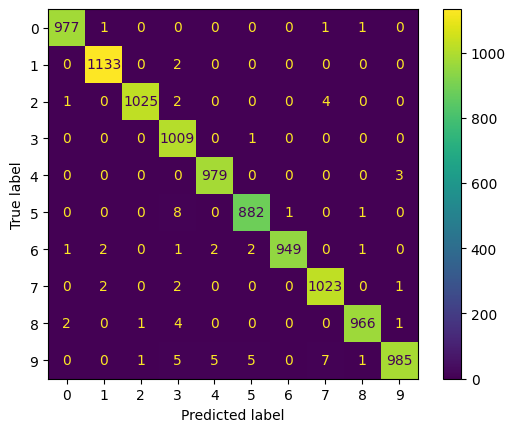

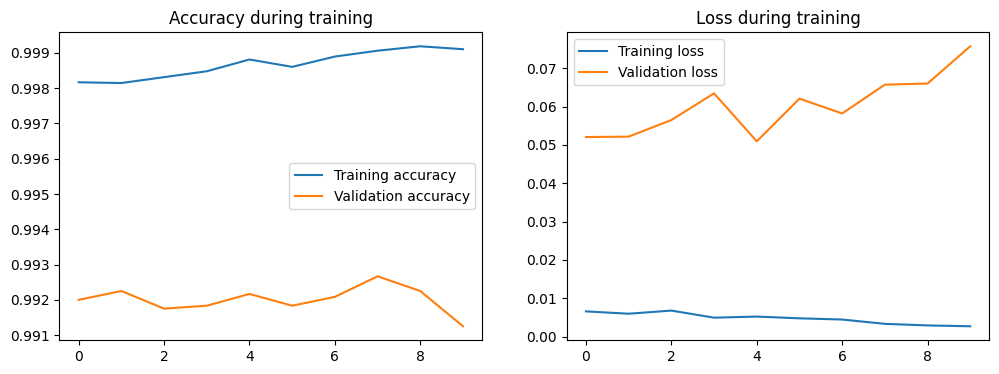

In [14]:
# Mostrar el reporte de clasificación
y_pred = np.argmax(best_model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_pred))

# Mostrar la matriz de confusión
ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
plt.show()

# Graficar la precisión y pérdida durante el entrenamiento
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Accuracy during training')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss during training')
plt.legend()

plt.show()

# Como construir un buen modelo


In [15]:

# Obtener los mejores hiperparámetros
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hyperparameters.values)

build_model(best_hyperparameters).summary()

{'filters_1': 32, 'kernel_size_1': 3, 'filters_2': 128, 'kernel_size_2': 5, 'units': 256, 'dropout': 0.4, 'optimizer': 'rmsprop'}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 9, 9, 128)           │         102,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 629,962 (2.40 MB)

 Trainable params: 629,962 (2.40 MB)

 Non-trainable params: 0 (0.00 B)

Realicemos ahora un aumento de datos, pequeñas rotaciones, pues el modelo tiende a overfitting, necesita más variedad de los datos para aprender comparando el tamaño que tiene

In [22]:
# Asegurarse de que los datos tengan 4 dimensiones (batch_size, height, width, channels)
X_train = np.expand_dims(X_train, axis=-1)  # De (28, 28) a (28, 28, 1)
X_val = np.expand_dims(X_val, axis=-1)      # De (28, 28) a (28, 28, 1)
X_test = np.expand_dims(X_test, axis=-1)    # De (28, 28) a (28, 28, 1)


In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping



# Crear un generador de datos con aumento
datagen = ImageDataGenerator(
    rotation_range=10,  # Rotación aleatoria de las imágenes entre -10 y 10 grados
    width_shift_range=0.1,  # Desplazamiento horizontal
    height_shift_range=0.1,  # Desplazamiento vertical
    zoom_range=0.1,  # Zoom aleatorio
    shear_range=0.1,  # Inclinación aleatoria
    horizontal_flip=False  # Volteo horizontal
)

# Ajustar el generador a los datos de entrenamiento
datagen.fit(X_train)

# Crear el modelo a partir de los mejores hiperparámetros
best_model = build_model(best_hyperparameters)

# EarlyStopping para evitar overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenar el modelo usando el generador de datos con aumento
history = best_model.fit(
    datagen.flow(X_train, y_train, batch_size=32),  # Aumento de datos aplicado al flujo de entrenamiento
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = best_model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")


Epoch 1/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 29s 18ms/step - accuracy: 0.8231 - loss: 0.5524 - val_accuracy: 0.9856 - val_loss: 0.0480
Epoch 2/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 38s 17ms/step - accuracy: 0.9698 - loss: 0.1012 - val_accuracy: 0.9895 - val_loss: 0.0379
Epoch 3/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - accuracy: 0.9776 - loss: 0.0768 - val_accuracy: 0.9912 - val_loss: 0.0340
Epoch 4/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - accuracy: 0.9802 - loss: 0.0660 - val_accuracy: 0.9902 - val_loss: 0.0404
Epoch 5/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - accuracy: 0.9829 - loss: 0.0591 - val_accuracy: 0.9905 - val_loss: 0.0360
Epoch 6/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - accuracy: 0.9823 - loss: 0.0601 - val_accuracy: 0.9854 - val_loss: 0.0558
Epoch 7/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 40s 16ms/step - accuracy: 0.9826 - loss: 0.0567 - val_accuracy: 0.9918 - val_loss: 0.0339
Epoch 8/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 40s 15ms/step - accuracy: 0.9852 -

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       980
           1       1.00      1.00      1.00      1135
           2       0.99      0.99      0.99      1032
           3       0.99      1.00      0.99      1010
           4       0.98      1.00      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       1.00      0.99      1.00       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



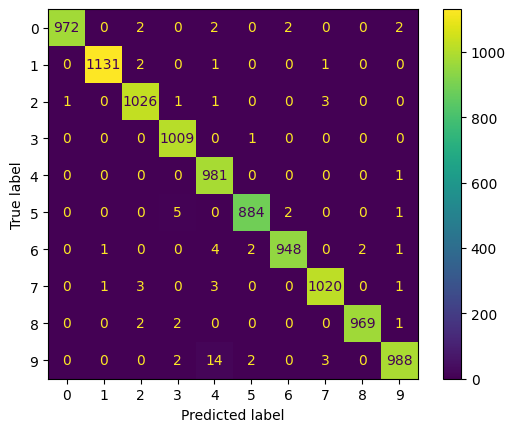

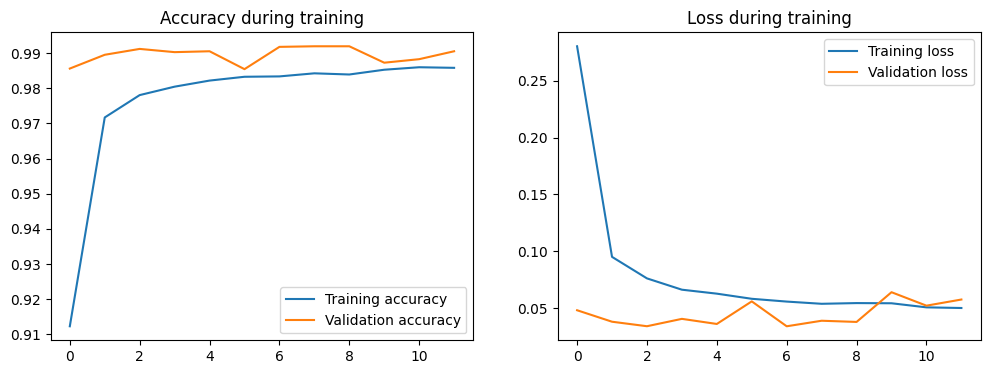

In [26]:
# Mostrar el reporte de clasificación
y_pred = np.argmax(best_model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_pred))

# Mostrar la matriz de confusión
ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
plt.show()

# Graficar la precisión y pérdida durante el entrenamiento
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Accuracy during training')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss during training')
plt.legend()

plt.show()

# Vamos a guarar el modelo y ejecutarlo despues

In [41]:
# prompt: save the best model recently created so it can be later impordes as a tflite by fastAPI

# Guardar el modelo en formato SavedModel
best_model.save('mnist_model.keras')


In [42]:
# prompt: load the mnist_model.keras in a variable called loaded_model

from tensorflow.keras.models import load_model

# Cargar el modelo desde el archivo
model = load_model('mnist_model.keras')


Veamos de que es capaz un modelo de apenas 2MB y sin aumento de datos

In [64]:
from google.colab import files
from matplotlib import font_manager
from PIL import Image # Import the Image class from PIL



def invert_colors(image_array):
    """Invierte los colores de la imagen: negro a blanco y viceversa."""
    return 1.0 - image_array  # Invertir los valores de 0 a 1


def predict_image(model, image_array):
    image_array = np.expand_dims(image_array, axis=0)  # Añadir dimensión del batch
    # Hacer la predicción con el modelo cargado
    prediction = model.predict(image_array)
    predicted_class = np.argmax(prediction)

    # Crear una figura con dos subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Primer subplot: Imagen con el número predicho
    axes[0].imshow(image_array[0, :, :, 0], cmap='gray')  # Mostrar la imagen en escala de grises
    font_prop = font_manager.FontProperties(family='serif', weight='bold', size=18)
    text = f"Predicción: {predicted_class}"
    axes[0].text(0.5, -0.1, text, fontsize=18, fontproperties=font_prop, color='blue', ha='center', transform=axes[0].transAxes)
    axes[0].set_title('Imagen Cargada (Transformada)')

    # Segundo subplot: Gráfico de barras de probabilidades de predicción
    axes[1].bar(range(10), prediction[0])  # Mostrar las probabilidades para cada clase
    axes[1].set_xticks(range(10))
    axes[1].set_xlabel('Clase')
    axes[1].set_ylabel('Probabilidad')
    axes[1].set_title('Probabilidades de Predicción')

    # Ajustar el layout y mostrar la figura
    plt.tight_layout()
    plt.show()

    # Mostrar la predicción en consola
    print(f"La imagen predicha es: {predicted_class}")
    return predicted_class


def predict_uploaded_image(model, pipeline=invert_colors):
    """
    Predice y visualiza una imagen cargada por el usuario.

    Args:
        model: El modelo de predicción cargado.
        pipeline: Una función que aplica una transformación personalizada a la imagen.
    """
    # Subir una imagen
    uploaded = files.upload()

    for fn in uploaded.keys():
        print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')

    # Cargar la imagen y preprocesarla
    image = Image.open(fn)
    image = image.convert('L')  # Convertir a escala de grises
    image = image.resize((28, 28))  # Redimensionar a 28x28 píxeles
    image_array = np.array(image)

    # Aplicar la función de pipeline (por ejemplo, invertir los colores)
    if pipeline is not None:
        image_array = pipeline(image_array)

    # Normalizar la imagen
    image_array = image_array.astype('float32') / 255.0

    # Expansión de la dimensión para agregar el canal y el tamaño del lote (1, 28, 28, 1)
    image_array = np.expand_dims(image_array, axis=-1)  # Añadir dimensión del canal


    predict_image(model, image_array)

# El modelo tiene poco pre procesamiento

En pos de ser un modelo simple y ver como son los problemas en la vida real; podemos entrenar un modelo muy bien, pero si los datos se encuentran en formatos distintos como fondo blanco o fondo negro, el modelo tendra problemas.

En entornos profesionales
- Agregar proceamiento previo

**Observemos que sucede si no invertimos los colores**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


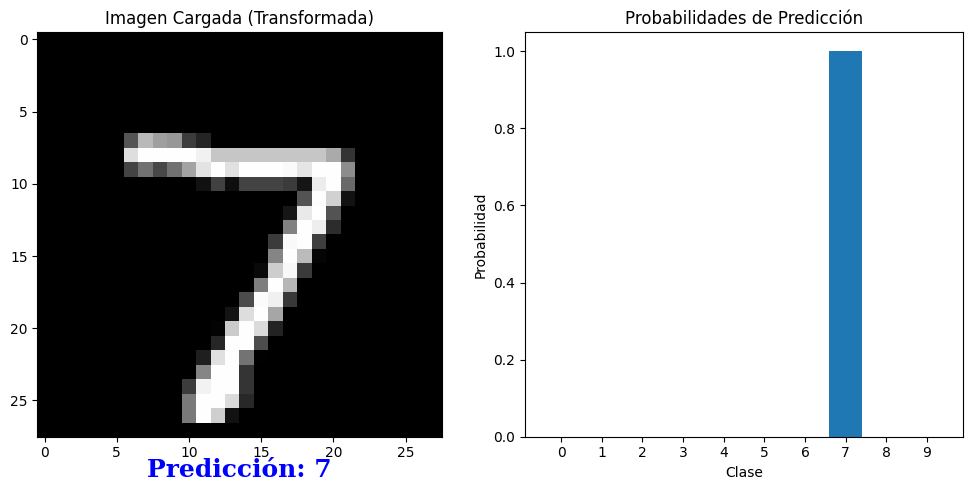

La imagen predicha es: 7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


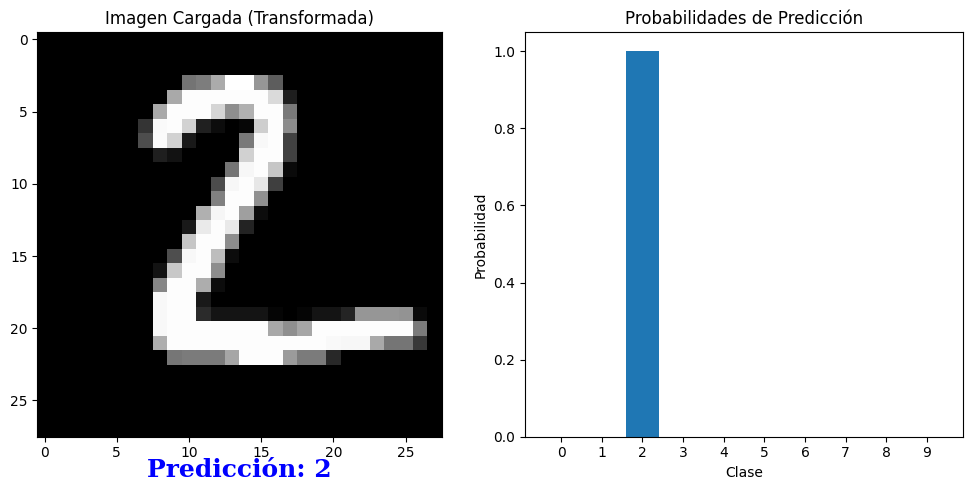

La imagen predicha es: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


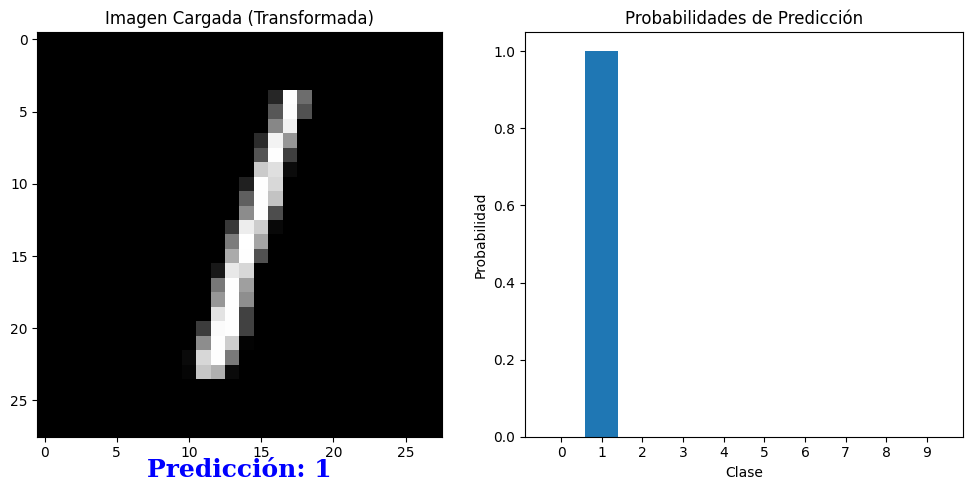

La imagen predicha es: 1


In [68]:
for idx in range(3):
  predict_image(model, X_test[idx])

Saving 7.png to 7.png
User uploaded file "7.png" with length 459 bytes
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


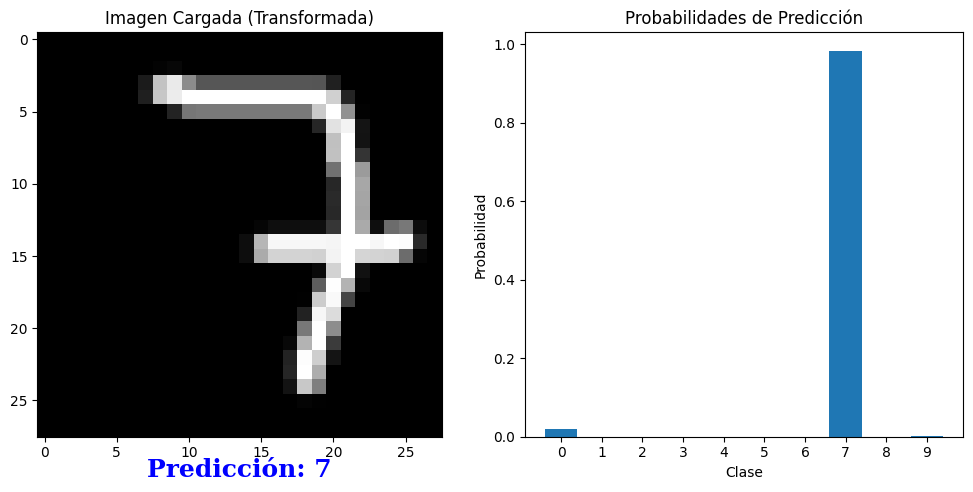

La imagen predicha es: 7


In [69]:
predict_uploaded_image(model)